In [1]:
# connect google drive in google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# install lib in google colab
# !pip install numpy
# !pip install -q opencv-python==4.5.5.64
# !pip install -q --force-reinstall albumentations==1.0.3
# !pip install torchmetrics
# !pip install torch
# !pip install pandas
# !pip install matplotlib
# !pip install Pillow
# !pip install opencv-python
# !pip install opencv-contrib-python
# !pip install segmentation_models_pytorch

In [3]:
import numpy as np
import cv2
import matplotlib as plt
import matplotlib.pyplot as plt
import torch
from  torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex #IOU
import segmentation_models_pytorch as smp
import albumentations as A
# to convert np.array to torch.tensor
from albumentations.pytorch import ToTensorV2
# others
import os
# processing effecting
from tqdm import tqdm
# read all images in a folder
from glob import glob

In [4]:
# declaration dataset
import os
import pandas as pd
from torchvision.io import read_image

class cityScapeDataset(Dataset):
    def __init__(self, root_dir, txt_file, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.txt_file = txt_file
        self.transform = transform
        self.img_path_list = []

        # get filename without extension
        with open(self.txt_file) as file_:
                for line in file_:
                    #TODO: modify with custom dataset
                    self.img_path_list.append(line.split('.')[0])


    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        #TODO: modify with custom dataset
        image_path = os.path.join(self.root_dir, "IMG", "{}.png".format(self.img_path_list[idx]))
        mask_path = os.path.join(self.root_dir, "MASK", "{}.png".format(self.img_path_list[idx]))
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed["image"]
            transformed_mask = transformed["mask"]
            return transformed_image, transformed_mask
        return image, mask

In [57]:
import albumentations as A
original_size = (1024, 2048)
train_size = (572, 572)

train_transform = A.Compose([
    A.RandomCrop(height=original_size[0]-50, width=original_size[1]-50),
    A.Resize (height=train_size[0], width=train_size[1], interpolation=1, always_apply=True, p=1),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=255),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])
test_transformt = A.Compose([
    A.RandomCrop(height=original_size[0]-50, width=original_size[1]-50),
    A.Resize (height=train_size[0], width=train_size[1], interpolation=1, always_apply=True, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

c:\Users\msnp\.conda\envs\python3dot8\lib\site-packages\albumentations\augmentations\transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [33]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

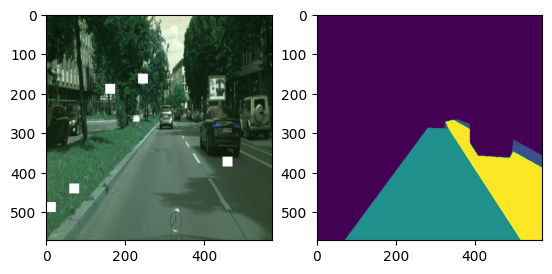

In [59]:
# test traindataset in google colab
# root_path = "/content/drive/MyDrive/FINAL_PROJECT_MLAI"

# test traindataset in google colab
root_path = "."

train_txt = root_path + "/trainval.txt"
test_txt  = root_path + "/test.txt"

train_dataset = cityScapeDataset(root_path, train_txt, train_transform)
test_dataset = cityScapeDataset(root_path, test_txt, test_transformt)

# test dataset
img, mask = train_dataset.__getitem__(2)
plt.subplot(1,2,1)
plt.imshow(unorm(img).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [54]:
import torch.nn as nn
import torch.nn.functional as F

#with (conv2d + pooling)x2
def Unet_Block(in_channels, out_channels):
    return nn.Sequential(
        #in_channels, out_channels, kernel_size, stride, padding
        nn.Conv2d(in_channels, out_channels, 3, 1, 0),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3,1, 0),
        nn.ReLU()
    )

class Unet_Model(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        # max pooling, kernel_size = 2
        self.max_pool  = nn.MaxPool2d(2)
        # interpolation
        self.block_down1 = Unet_Block(3, 64)
        self.block_down2 = Unet_Block(64, 128)
        self.block_down3 = Unet_Block(128, 256)
        self.block_down4 = Unet_Block(256, 512)

        self.block_neck  = Unet_Block(512, 1024)

        self.up_conv_1  = nn.Upsample(size=(64,64), mode="bilinear")
        self.block_up1   = Unet_Block(1024 + 512, 512)
        self.up_conv_2  = nn.Upsample(size=(136,136), mode="bilinear")
        self.block_up2   = Unet_Block(512+256, 256)
        self.up_conv_3  = nn.Upsample(size=(280, 280), mode="bilinear")
        self.block_up3   = Unet_Block(256+128, 128)
        self.up_conv_4  = nn.Upsample(size=(568,568), mode="bilinear")
        self.block_up4   = Unet_Block(128+64, 64)
        # B, n_classes, H, W
        self.up_conv_5  = nn.Upsample(size=(train_size[0],train_size[1]), mode="bilinear")
        self.conv_classify = nn.Conv2d(64, self.n_classes, 1, 1)

    def forward(self, x):
        # encoder
        # print("INPUT: ", x.shape)
        x1 = self.block_down1(x)
        # print("DOWN1: ", x1.shape)
        x = self.max_pool(x1)
        # print("MAXPOOL: ", x.shape, "\n")
        x2 = self.block_down2(x)
        # print("DOWN2: ", x2.shape)
        x = self.max_pool(x2)
        # print("MAXPOOL: ", x.shape, "\n")
        x3 = self.block_down3(x)
        # print("DOWN3: ", x3.shape)
        x = self.max_pool(x3)
        # print("MAXPOOL: ", x.shape, "\n")
        x4 = self.block_down4(x)
        # print("DOWN4: ", x4.shape)
        x = self.max_pool(x4)
        # print("MAXPOOL: ", x.shape, "\n")

        #neck
        x = self.block_neck(x)
        # print("NECK: ", x.shape, "\n")

        #decoder
        #[b c=1024 h w] cat [b c=512 h w] -> [b c=1536 h w]  (dim=1 - channel)
        x = torch.cat([x4, self.up_conv_1(x)], dim=1)
        # print("CAT1: ", x.shape)
        x = self.block_up1(x)
        # print("UP1: ", x.shape, "\n")
        x = torch.cat([x3, self.up_conv_2(x)], dim=1)
        # print("CAT2: ", x.shape)
        x = self.block_up2(x)
        # print("UP2: ", x.shape, "\n")
        x = torch.cat([x2, self.up_conv_3(x)], dim=1)
        # print("CAT3: ", x.shape)
        x = self.block_up3(x)
        # print("UP3: ", x.shape, "\n")
        x = torch.cat([x1, self.up_conv_4(x)], dim=1)
        # print("CAT4: ", x.shape)
        x = self.block_up4(x)
        # print("UP4: ", x.shape, "\n")

        x = self.up_conv_5(x)
        return self.conv_classify(x)


In [53]:
# AverageMeter used for storing acc, loss, cost value in training process
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

# accurancy fn
def accurancy_fn(preds, targets):
    preds_f = preds.flatten()
    targets_f = targets.flatten()
    accurancy_val = torch.sum(preds_f == targets_f)
    return accurancy_val / targets_f.shape[0]

In [52]:
# model
n_classes = 1
my_ss_model = Unet_Model(n_classes)  # CPU trainning
# my_ss_model = Unet_Model(1).to(device) # GPU trainning

In [51]:
# loss
criterion = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = optimizer = torch.optim.Adam(my_ss_model.parameters(), lr=1e-4)
# epoches
n_eos = 1
# metrics
Dice_fn = torchmetrics.Dice(num_classes=n_classes, average="macro")
IOU_fn  = torchmetrics.JaccardIndex(num_classes=n_classes, task='binary', average="macro")

# meter
accurancy_metter = AverageMeter()
train_loss_metter = AverageMeter()
Dice_meter        =  AverageMeter()
IOU_meter        =  AverageMeter()

In [66]:
# device
# device = torch.device("cuda" if torch.cuda.is_available else "cpu")
#TODO: if CPU, manually change device = "cpu"
device = "cpu"
print(device)

# load data
batch_size = 1
# n_workers = os.cpu_count()
n_workers = 1
print("num_workers: ", n_workers)
# load data and store to a group call a batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=n_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                    shuffle=False, num_workers=n_workers)

cpu
num_workers:  1


In [67]:
# trainning
n_epoches = 3
for ep in range(1, 1+n_epoches):
  
  # reset meter
  accurancy_metter.reset()
  train_loss_metter.reset()
  Dice_meter.reset()
  IOU_meter.reset()
  # trainning with every batch
  for batch_ndx, sample in enumerate(train_loader):
  #   n      = i_img.shape[0]
    print(sample.inp.is_pinned())
    print(sample.tgt.is_pinned())

  #   i_img  = i_img.to(device).float()
  #   mask_img   = mask_img.to(device).float()

  #   optimizer.zero_grad()
  #   output = my_ss_model(i_img)

  #   output = output.squeeze(dim=0)
  #   loss = criterion(o_img, mask_img)

  #   # back-probagation and optimizing
  #   loss.backward()
  #   optimizer.step()


RuntimeError: DataLoader worker (pid(s) 17292) exited unexpectedly